Unitary iDMRG with bond dimension D = 4

In [1]:
import numpy as np
import cmath
import math
from scipy.stats import unitary_group
import scipy.linalg
from scipy import integrate
from ncon import ncon 
from matplotlib import pyplot as plt
import pickle 

###############################################################################################################
                                            # HELPER FUNCTIONS #
###############################################################################################################

def polar(mat):
    '''computes polar decomposition'''
    xl, _, xr = np.linalg.svd(mat)
    return ncon([xl, xr], [[-1, 1], [1, -2]])

def get_s(d):
    '''returns a spin-up vector'''
    s = np.zeros(d)
    s[0] = 1
    return s

def transverse_ising_soln(J, g):
    '''returns exact ground state energy of transverse ising model'''
    # andrew's code excerpt
    f = lambda k,J,g : -2*np.sqrt(J**2 + g**2 - 2*g*J*np.cos(k))/np.pi/2.
    E0_exact = integrate.quad(f, 0, np.pi, args=(J, g))[0]
    return E0_exact
          
def plot_fn(E, xlabel='x', ylabel='y'):
    E = np.array(E)
    xpoints = np.arange(1, len(E)+1, 1)
    fig, ax = plt.subplots()
    ax.plot(xpoints, E.real)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show();
    
def plot_E(E, xlabel='x', ylabel='y'):
    E = np.array(E)
    xpoints = np.linspace(1, length, len(E), endpoint=True)
    fig, ax = plt.subplots()
    ax.plot(xpoints, E.real)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show();
        
def savedata(filename, save=False):
    if save == True:
        with open(filename + '.pkl', 'wb') as f:
            pickle.dump(data, f) 
        data_list = ['J', 'g', 'E0_exact', 'E0', 'params']
        data_list.append([data["J"], data["g"], data["E0_exact"], data["E0"], data["params"][1]])
        with open(filename + '.txt', "w") as output:
            output.write(str(data_list))
    return

def load_data(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)
    
def transverse_ising_soln(J, g):
    '''returns exact ground state energy of transverse ising model'''
    # andrew's code excerpt
    f = lambda k,J,g : -2*np.sqrt(J**2 + g**2 - 2*g*J*np.cos(k))/np.pi/2.
    E0_exact = integrate.quad(f, 0, np.pi, args=(J, g))[0]
    return E0_exact

In [2]:
def optimise_2site():
    '''optimise hamiltonian on 2 sites'''
    u = unitary_group.rvs(d*d)
    u = u.reshape(d,d,d,d)
    energy = lambda u : ncon([s, s, u, HC, np.conj(u), s, s], 
                             ([1], [2], [1,2,3,4], [4,3,5,6], [7,8,6,5], [7], [8]))
    Es.append(energy(u))
    for it in range(iters):
        M = ncon([s, s, u, HC_alpha, s, s], ([1], [2], [1,2,3,4], [4,3,-4,-3], [-1], [-2]))
        M = M.reshape(d*d, d*d)
        u = polar(M).reshape(d,d,d,d)
        Es.append(energy(u))
    return u

def energy_3site(u):
    '''compute energy on 3 sites'''
    # H computed on left and centre sites
    energy_left = ncon([s,s,s, u, u, HL, np.conj(u), np.conj(u), s,s,s],
                ([1], [5], [6], [1,2,3,4], [5,6,7,2], [4,3,8,9], [10,11,9,8], [12,13,7,11], [10], [12], [13]))
    # H on centre and right sites
    energy_right = ncon([s,s,s, u, u, HR, np.conj(u), np.conj(u), s,s,s],
                ([1], [5], [6], [1,2,3,4], [5,6,7,2], [3,7,8,9], [10,11,8,4], [12,13,9,11], [10], [12], [13]))
    return (energy_left + energy_right)/2

def optimise_3site(u):
    '''optimise hamiltonian on 3 sites'''
    Es.append(energy_3site(u))
    for it in range(iters):
        if it%2 == 0: # chop left np.conj(u).T from circuit
            M_l = ncon([s,s,s, u, u, HL, np.conj(u), s,s,s],
                    ([1], [5], [6], [1,2,3,4], [5,6,7,2], [4,3,-4,-3], [12,13,7,-2], [-1], [12], [13]))
            M_r = ncon([s,s,s, u, u, HR, np.conj(u), s,s,s],
                    ([1], [5], [6], [1,2,3,-4], [5,6,7,2], [3,7,-3,9], [12,13,9,-2], [-1], [12], [13]))
        else: # chop right np.conj(u).T from circuit
            M_l = ncon([s,s,s, u, u, HL, np.conj(u), s,s,s],
                    ([1], [5], [6], [1,2,3,4], [5,6,-3,2], [4,3,8,9], [10,-4,9,8], [10], [-1], [-2]))
            M_r = ncon([s,s,s, u, u, HR, np.conj(u), s,s,s],
                    ([1], [5], [6], [1,2,3,4], [5,6,7,2], [3,7,8,-3], [10,-4,8,4], [10], [-1], [-2]))
        M = (M_l + M_r).reshape(d*d,d*d)
        u = polar(M).reshape(d,d,d,d) # update u
        Es.append(energy_3site(u))
    return u

def energy_u1(u1, u0):
    '''computes energy when right environment is the identity'''
    energy_left = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HL, np.conj(u0), np.conj(u1), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,14,11,10], [4,5,15,13], [8,12,16,17],
        [18,19,16,9], [20,21,22,17,19,18], [23,24,25,14,22,21], [26,27,15,25], [20], [23], [24], [26], [27]))
    
    energy_centre = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HC, np.conj(u0), np.conj(u1), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,14,11,10], [4,5,15,13], [12,14,16,17],
        [18,19,8,9], [20,21,22,16,19,18], [23,24,25,17,22,21], [26,27,15,25], [20], [23], [24], [26], [27]))
    
    energy_right = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HR, np.conj(u0), np.conj(u1), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,14,11,10], [4,5,15,13], [14,15,16,17],
        [18,19,8,9], [20,21,22,12,19,18], [23,24,25,16,22,21], [26,27,17,25], [20], [23], [24], [26], [27]))
    return (energy_left + energy_centre + energy_right)/3

def update_u1_left(u1, u0):
    '''chops left u1 from circuit and returns updated u1'''
    M_l = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HL_alpha, np.conj(u0), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,14,11,10], [4,5,15,13], [8,12,16,-4],
        [-6,-5,16,9], [23,24,25,14,-3,-2], [26,27,15,25], [-1], [23], [24], [26], [27]))
    
    M_c = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HC_alpha, np.conj(u0), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,14,11,10], [4,5,15,13], [12,14,-4,17],
        [-6,-5,8,9], [23,24,25,17,-3,-2], [26,27,15,25], [-1], [23], [24], [26], [27]))
    
    M_r = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HR_alpha, np.conj(u0), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,-4,7,6], [2,3,13,14,11,10], [4,5,15,13], [14,15,16,17],
        [-6,-5,8,9], [23,24,25,16,-3,-2], [26,27,17,25], [-1], [23], [24], [26], [27]))
    M = (M_l + M_c + M_r).reshape(d*D, d*D)
    return polar(M).reshape(d,d,d,d,d,d)

def update_u1_right(u1,u0):
    '''chops right u1 from circuit and returns updated u1'''
    M_l = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HL_alpha, np.conj(u0), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,-4,11,10], [4,5,15,13], [8,12,16,17],
        [18,19,16,9], [20,-6,-5,17,19,18], [26,27,15,-3], [20], [-1], [-2], [26], [27]))
    
    M_c = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HC_alpha, np.conj(u0), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,14,11,10], [4,5,15,13], [12,14,16,-4],
        [18,19,8,9], [20,-6,-5,16,19,18], [26,27,15,-3], [20], [-1], [-2], [26], [27]))
    
    M_r = ncon(
        [s,s,s,s,s, u0, u1, u1, u0, HR_alpha, np.conj(u0), np.conj(u1), np.conj(u0), s,s,s,s,s],
        ([1], [2], [3], [4], [5], [6,7,8,9], [1,10,11,12,7,6], [2,3,13,14,11,10], [4,5,15,13], [14,15,-4,17],
        [18,19,8,9], [20,-6,-5,12,19,18], [26,27,17,-3], [20], [-1], [-2], [26], [27]))
    M = (M_l + M_c + M_r).reshape(d*D, d*D)
    return polar(M).reshape(d,d,d,d,d,d)
    
def optimise_u1(u0):
    '''optimises centre sites when right env is identity'''
    u1 = unitary_group.rvs(d*D)
    u1 = u1.reshape((d,)*6)
    Es.append(energy_u1(u1,u0))
    for it in range(iters):
        if it%2 == 0:
            u1 = update_u1_left(u1,u0)
        else:
            u1 = update_u1_right(u1,u0)
        Es.append(energy_u1(u1,u0))
    return u1

def energy_u2(u2,u1,R0):
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HL,np.conj(u1),np.conj(u2),np.conj(u2),np.conj(u1), s,s,s,s,s]
    energy_left = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[4,10,19,20],[21,22,23,19,5,6],[24,25,26,20,23,22],
                  [27,28,29,14,26,25],[30,31,32,18,29,28],[21],[24],[27],[30],[31])
    )
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HC,np.conj(u1),np.conj(u2),np.conj(u2),np.conj(u1), s,s,s,s,s]
    energy_centre = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[10,14,19,20],[21,22,23,4,5,6],[24,25,26,19,23,22],
                  [27,28,29,20,26,25],[30,31,32,18,29,28],[21],[24],[27],[30],[31])
    )
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HR,np.conj(u1),np.conj(u2),np.conj(u2),np.conj(u1), s,s,s,s,s]
    energy_right = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[14,18,19,20],[21,22,23,4,5,6],[24,25,26,10,23,22],
                  [27,28,29,19,26,25],[30,31,32,20,29,28],[21],[24],[27],[30],[31])
    )
    return (energy_left + energy_centre + energy_right)/3

def update_u2_left(u2,u1,R0):
    '''chops left np.conj(u2) from circuit and returns updated u2'''
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HL_alpha,np.conj(u1),np.conj(u2),np.conj(u1), s,s,s,s,s]
    M_l = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[4,10,19,-4],[21,-6,-5,19,5,6],
                  [27,28,29,14,-3,-2],[30,31,32,18,29,28],[21],[-1],[27],[30],[31])
    )
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HC_alpha,np.conj(u1),np.conj(u2),np.conj(u1), s,s,s,s,s]
    M_c = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[10,14,-4,20],[21,-6,-5,4,5,6],
                  [27,28,29,20,-3,-2],[30,31,32,18,29,28],[21],[-1],[27],[30],[31])
    )
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HR_alpha,np.conj(u1),np.conj(u2),np.conj(u1), s,s,s,s,s]
    M_r = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,-4,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[14,18,19,20],[21,-6,-5,4,5,6],
                  [27,28,29,19,-3,-2],[30,31,32,20,29,28],[21],[-1],[27],[30],[31])
    )
    M = (M_l + M_c + M_r).reshape(d*D,d*D)
    return polar(M).reshape(d,d,d,d,d,d)

def update_u2_right(u2,u1,R0):
    '''chops right np.conj(u2) from circuit and returns updated u2'''
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HL_alpha,np.conj(u1),np.conj(u2),np.conj(u1), s,s,s,s,s]
    M_l = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,-4,9,8],
                  [15,16,17,18,13,12],[17,32],[4,10,19,20],[21,22,23,19,5,6],[24,-6,-5,20,23,22],
                  [30,31,32,18,-3,-2],[21],[24],[-1],[30],[31])
    )
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HC_alpha,np.conj(u1),np.conj(u2),np.conj(u1), s,s,s,s,s]
    M_c = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[10,14,19,-4],[21,22,23,4,5,6],[24,-6,-5,19,23,22],
                  [30,31,32,18,-3,-2],[21],[24],[-1],[30],[31])
    )
    
    tensors = [s,s,s,s,s,u1,u2,u2,u1,R0,HR_alpha,np.conj(u1),np.conj(u2),np.conj(u1), s,s,s,s,s]
    M_r = ncon(
        tensors, ([1],[7],[11],[15],[16],[1,2,3,4,5,6],[7,8,9,10,2,3],[11,12,13,14,9,8],
                  [15,16,17,18,13,12],[17,32],[14,18,-4,20],[21,22,23,4,5,6],[24,-6,-5,10,23,22],
                  [30,31,32,20,-3,-2],[21],[24],[-1],[30],[31])
    )
    M = (M_l + M_c + M_r).reshape(d*D,d*D)
    return polar(M).reshape(d,d,d,d,d,d)
     
def optimise_u2(u1, u0):
    '''returns optimised u2 and right env R1'''
    u2 = u1.copy()
    R0 = ncon([s,s,u0,np.conj(u0),s,s], ([1], [2], [1,2,3,-1], [4,5,3,-2], [4], [5]))
    Es.append(energy_u2(u2,u1,R0))
    for it in range(iters):
        if it%2 == 0:
            u1 = update_u2_left(u2,u1,R0)
        else:
            u1 = update_u2_right(u2,u1,R0)
        Es.append(energy_u2(u2,u1,R0))
        
    R1 = ncon([s,s,u1,R0,np.conj(u1),s,s], ([1], [2], [1,2,3,4,-2,-1], [3,5], [6,7,5,4,-4,-3], [6], [7]))
    R1 = R1.reshape(D,D)
    return u2, R1

def energy_un(un, unm1, Rnm1):
    '''returns energy at the nth step'''
    energy_left = ncon(
        [s,s,s,s, unm1, un, un, unm1, HL, Rnm1, np.conj(unm1), np.conj(un), np.conj(un),np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1, 8, 11, 10], [2, 9, 12, 8], [3, 6, 13, 9], [4, 5, 7, 6], [11, 12, 14, 15], 
         [5, 23], [16, 17, 14, 10], [18, 19, 15, 17], [20, 21, 13, 19], [22, 23, 7, 21], [16], [18],[20], [22])
    )
    energy_centre = ncon(
        [s,s,s,s, unm1, un, un, unm1, HC, Rnm1, np.conj(unm1), np.conj(un),np.conj(un),np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1, 8, 13, 12], [2, 7, 9, 8], [3, 6, 10, 7], [4, 5, 11, 6], [9, 10, 14, 15], 
         [5, 23], [16, 17, 13, 12], [18, 19, 14, 17], [20, 21, 15, 19],[22, 23, 11, 21], [16], [18], [20],[22])
    )
    energy_right = ncon(
        [s,s,s,s, unm1, un, un, unm1, HR, Rnm1, np.conj(unm1),np.conj(un), np.conj(un), np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1, 8, 13, 12], [2, 7, 9, 8], [3, 6, 10, 7], [4, 5, 11, 6], [10, 11, 14, 15],
         [5, 23],[16, 17, 13, 12], [18, 19, 9, 17], [20, 21, 14, 19], [22, 23, 15, 21], [16], [18], [20], [22])
    )
    return (energy_left + energy_centre + energy_right)/3

def update_un_left(un, unm1, Rnm1):
    '''chops left un from circuit and returns updated un'''
    M_l = ncon(
        [s,s,s,s, unm1, un, un, unm1, HL_alpha, Rnm1, np.conj(unm1), np.conj(un), np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6], [13, 11, 14, -3], 
         [5, 19], [15, -4, 14, 12], [16, 17, 9, -2], [18, 19, 7, 17], [15], [-1], [16], [18])
    )
    M_c = ncon(
        [s,s,s,s, unm1, un, un, unm1, HC_alpha, Rnm1, np.conj(unm1), np.conj(un), np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1,10,13,12], [2,8,11,10], [3,6,9,8], [4,5,7,6], [11,9,-3,14], [5,19], 
         [15,-4,13,12], [16,17,14,-2], [18,19,7,17], [15], [-1], [16], [18])
    )
    M_r = ncon(
        [s,s,s,s, unm1, un, un, unm1, HR_alpha, Rnm1, np.conj(unm1), np.conj(un), np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1, 9, 12, 11], [2, 8, -3, 9], [3, 6, 10, 8], [4, 5, 7, 6],
               [10, 7, 14, 15], [5, 19], [13, -4, 12, 11], [16, 17, 14, -2], [18, 19, 15, 17],
               [13], [-1], [16], [18])
    )
    M = (M_l + M_c + M_r).reshape(d*D,d*D)
    return polar(M).reshape(d,D,d,D)
    
def update_un_right(un,unm1,Rnm1):
    '''chops right un from circuit and returns updated un'''
    M_l = ncon(
        [s,s,s,s, unm1, un, un, unm1, HL_alpha, Rnm1, np.conj(unm1), np.conj(un), np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1, 9, 11, 12], [2, 8, 10, 9], [3, 6, -3, 8], [4, 5, 7, 6],[11, 10, 13, 14], 
         [5, 19], [15, 16, 13, 12], [17, -4, 14, 16], [18, 19, 7, -2], [15], [17], [-1], [18])
    )
    M_c = ncon(
        [s,s,s,s, unm1, un, un, unm1, HC_alpha, Rnm1, np.conj(unm1), np.conj(un), np.conj(unm1), s,s,s,s],
    ([1], [2], [3], [4], [4, 5, 7, 6], [3, 6, 11, 8], [2, 8, 10, 9], [1, 9, 13, 12], [10, 11, 16, -3], 
     [5, 19], [14, 15, 13, 12], [17, -4, 16, 15], [18, 19, 7, -2], [14], [17], [-1], [18])
    )
    M_r = ncon(
        [s,s,s,s, unm1, un, un, unm1, HR_alpha, Rnm1, np.conj(unm1), np.conj(un), np.conj(unm1), s,s,s,s],
        ([1], [2], [3], [4], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6], [9, 7, -3, 14], 
         [5, 19], [16, 15, 13, 12], [17, -4, 11, 15], [18, 19, 14, -2], [16], [17], [-1], [18])
    )
    M = (M_l + M_c + M_r).reshape(d*D,d*D)
    return polar(M).reshape(d,D,d,D)

def get_r(u, Rprev):
    '''returns right environment'''
    Rnew = ncon((s, u, Rprev, np.conj(u), s), ([1], [1, 2, 3, -1], [2, 5], [4, 5, 3, -2], [4]))
    return Rnew/np.trace(Rnew) 
    
def optimise_un(unm1, Rnm2):
    '''returns optimised un and Rnm1 (i.e. the right environment of un)'''
    unm1 = unm1.reshape(d,D,d,D)
    un = unm1.copy()
    Es.append(energy_un(un,unm1,Rnm2))
    for it in range(iters):
        if it%2 == 0:
            un = update_un_left(un,unm1,Rnm2)
        else:
            un = update_un_right(un,unm1,Rnm2)
        Es.append(energy_un(un,unm1,Rnm2))
    Rnm1 = get_r(unm1,Rnm2)
    return un, Rnm1

def TI_energy(un):
    '''returns the energy of a translationally invariant state'''
    # the free indices have this order so that the eigensolver uses the correct axes of M
    E = ncon((s, un, np.conj(un), s), ([1], [1, -2, 2, -4], [3, -3, 2, -1], [3]))
    E = ncon((E), ([-2, -3, -4, -1]))
    E = E.reshape(D*D, D*D)
    e, R = scipy.sparse.linalg.eigen.arpack.eigs(E,k=1,which='LM')
    R = R.reshape(D, D)
    R = R/np.trace(R)
    overlap = ncon(
        [s, s, un, un, R, np.conj(un), np.conj(un), s, s], 
        ([1], [2], [1, 4, 7, 6], [2, 3, 5, 4], [3, 11], [8, 9, 7, 6], [10, 11, 5, 9], [8], [10])
    )
    energy = ncon([s,s, un, un, h, R, np.conj(un), np.conj(un), s,s],
    ([1],[2], [2, 3, 5, 4], [1, 4, 7, 6], [7, 5, 8, 9], [3, 13], [10, 11, 8, 6], [12, 13, 9, 11], [10], [12])
        )
    return energy/overlap

def R_diff(un, Rn):
    '''Returns mean of absolute difference between R_n and R_(n+1)'''
    R = get_r(un,Rn)
    return np.mean(R-Rn)

def fp_distance(un, Rn):
    '''Returns fixed point distance'''
    E = ncon((s, un, np.conj(un), s), ([1], [1, -2, 2, -4], [3, -3, 2, -1], [3]))
    E = ncon((E), ([-2, -3, -4, -1]))
    E = E.reshape(D*D, D*D)
    e, R = scipy.sparse.linalg.eigen.arpack.eigs(E,k=1,which='LM')
    R = R.reshape(D, D)
    R = R/np.trace(R)
    return np.mean(np.abs(R-Rn))
    
def __main__(length, iters):
    global d, D, s, s_virtual, Es, TI_energies, RD, FPD
    d = 2
    D = 4
    s = get_s(d)
    s_virtual = get_s(D)
    Es = []
    TI_energies = []
    RD = []
    FPD = []
    u0 = optimise_3site(optimise_2site())
    u1 = optimise_u1(u0)
    u2, R1 = optimise_u2(u1,u0)
    unm1, Rnm2 = optimise_un(u2, R1)
    for n in range(length):
        un, Rnm1 = optimise_un(unm1, Rnm2)
        TI_energies.append(TI_energy(un))# construct trf matrix and calculate energy
        unm1 = un.copy()
        Rnm2 = Rnm1.copy()
        RD.append(R_diff(unm1,Rnm2))
        FPD.append(fp_distance(unm1,Rnm2))
    print('-'*100)
    print('EXACT SOLN', transverse_ising_soln(J,g))
    print('TI ENERGY:', TI_energies[-1])
    print('EXIT')
    print('-'*100)

In [9]:
J = 1
g = 1.1
d = 2
D = 4
X = np.array([[0.,1.],[1.,0.]])
Z = np.array([[1.,0.],[0.,-1.]])
h = -J*np.kron(Z,Z) + g * (1.0*np.kron(X, np.eye(d)) + 0.*np.kron(np.eye(d), X))

HL = h
HC = h
HR = h
# HL = -J*np.kron(Z,Z) + g * (1.*np.kron(X, np.eye(d)) + 0.5*np.kron(np.eye(d), X))
# HC = -J*np.kron(Z,Z) + g * (0.5*np.kron(X, np.eye(d)) + 0.5*np.kron(np.eye(d), X))
# HR = -J*np.kron(Z,Z) + g * (0.5*np.kron(X, np.eye(d)) + 1.0*np.kron(np.eye(d), X))

alpha = -1
h_alpha = h + alpha * np.eye(d*d)
HL_alpha = HL + alpha * np.eye(d*d)
HC_alpha = HC + alpha * np.eye(d*d)
HR_alpha = HR + alpha * np.eye(d*d)
h = h.reshape(d,d,d,d)
HL = HL.reshape(d,d,d,d)
HC = HC.reshape(d,d,d,d)
HR = HR.reshape(d,d,d,d)
h_alpha.reshape(d,d,d,d)
HL_alpha = HL_alpha.reshape(d,d,d,d)
HC_alpha = HC_alpha.reshape(d,d,d,d)
HR_alpha = HR_alpha.reshape(d,d,d,d)

----------------------------------------------------------------------------------------------------
EXACT SOLN -1.3428640227251263
TI ENERGY: (-1.3165153221026293-4.580012136518055e-14j)
EXIT
----------------------------------------------------------------------------------------------------
(-1.3212515373559148+8.095376221225099e-18j)


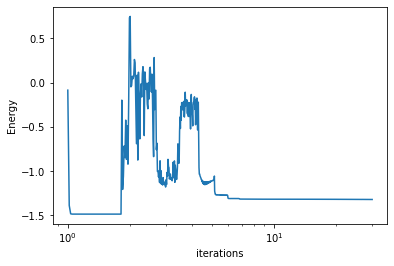

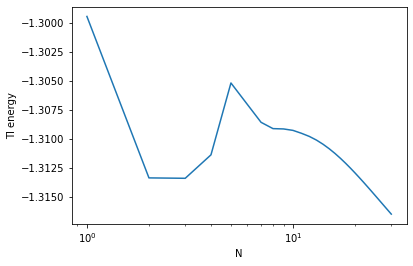

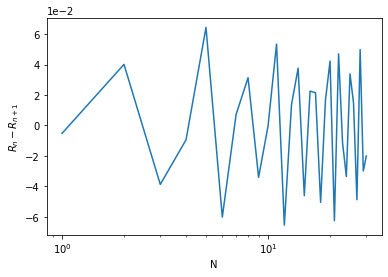

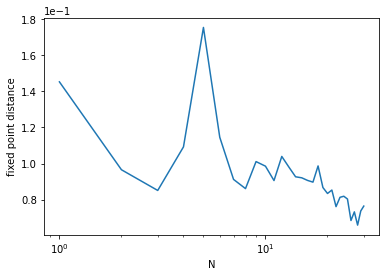

In [10]:

length = 50
iters = 50
__main__(length, iters)
print(np.array(Es)[-1])
plot_E(Es, xlabel = 'iterations', ylabel='Energy')
plot_fn(TI_energies, xlabel = 'N', ylabel='TI energy')
plot_fn(RD, xlabel='N', ylabel="$R_n - R_{n+1}$")
plot_fn(FPD, xlabel='N', ylabel='fixed point distance')